In [11]:
# install stuff
!pip install -U keras nltk
!pip install -U tensorflow==1.3
!pip install -U glove_python

Requirement already up-to-date: keras in /usr/local/lib/python2.7/dist-packages (2.2.4)
Requirement already up-to-date: nltk in /usr/local/lib/python2.7/dist-packages (3.3)
Requirement already up-to-date: tensorflow==1.3 in /usr/local/lib/python2.7/dist-packages (1.3.0)
    100% |████████████████████████████████| 266kB 14.8MB/s 
  Running setup.py bdist_wheel for glove-python ... - \ | / - \ | done
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print (" SystemError('GPU device not found It is ok, you only need for training'")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
#install import stuff
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 22278 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.0-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleus

In [0]:
#mount google drive
!mkdir -p drive
!google-drive-ocamlfuse drive

In [24]:
%cd drive
%mkdir NLP
%cd NLP
#download model parameters
!git clone https://github.com/leexa90/RNN_simple
%cd RNN_simple
%ls -lh

/root
mkdir: cannot create directory ‘NLP’: File exists
/root/NLP
fatal: destination path 'RNN_simple' already exists and is not an empty directory.
/root/NLP/RNN_simple
total 170M
-rw-r--r-- 1 root root 3.0M Oct 23 05:44 file2.npy
-rw-r--r-- 1 root root 2.9M Oct 23 05:44 file.npy
-rw-rw-r-- 1 root root 164M Aug  4  2014 glove.6B.50d.txt
-rw-r--r-- 1 root root  89K Oct 23 05:44 HWK3_RNN.ipynb
-rw-r--r-- 1 root root   58 Oct 23 05:44 README.md


In [0]:
!if [ ! -f "glove.6B.50d.txt" ]; then wget http://nlp.stanford.edu/data/glove.6B.zip ;unzip glove.6B.zip;rm glove.6B.zip;rm glove.6B.*00d.txt;fi

In [13]:
import numpy as np
import os
import nltk
import pandas as pd
import tensorflow as tf
import tensorflow.contrib.keras as keras
import numpy as np
import pickle


print tf.__version__
print nltk.__version__
print pd.__version__

1.3.0
3.3
0.22.0


In [0]:
#from tensorflow.contrib.keras.api.keras.preprocessing import sequence
from tensorflow.contrib.keras.api.keras.layers import Input, Embedding, GRU, Dense #, Activation
from tensorflow.contrib.keras.api.keras.models import Model
from tensorflow.contrib.keras.python.keras.layers import Bidirectional, TimeDistributed


In [0]:
SENTENCE_LENGTH_MAX = 80
EMBEDDING_DIM=50

In [6]:
# scraped data file
data = np.load('file.npy')
data = pd.DataFrame(data,columns=['year', 'date', 'time', 'data', 'site', 'site2', 'date2', 'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','Change']) 
print data.head()
data.to_csv('data.csv')

   year       date   time                                               data  \
0  2016  oct_9.txt  06:23  Table Tennis: Feng Tianwei upset by Japanese t...   
1  2016  oct_9.txt  06:00  Football: Immobile brings Italy back from the ...   
2  2016  oct_9.txt  04:39  Football: Napoli striker Milik out for â€˜mont...   
3  2016  oct_9.txt  04:23  Thousands of armed Yemeni protesters call for ...   
4  2016  oct_9.txt  04:05  Football: Wales drop World Cup points in Georg...   

                 site                               site2     date2  \
0  http://str.sg/4xhn  [http://str.sg/4xhn, PHOTO:, ITTF]  [10, 09]   
1  http://str.sg/4xhW   [http://str.sg/4xhW, PHOTO:, EPA]  [10, 09]   
2  http://str.sg/4xeY   [http://str.sg/4xeY, PHOTO:, EPA]  [10, 09]   
3  http://str.sg/4xef   [http://str.sg/4xef, PHOTO:, AFP]  [10, 09]   
4  http://str.sg/4xeN   [http://str.sg/4xeN, PHOTO:, AFP]  [10, 09]   

         Date      Open      High       Low     Close Adj Close  Volume Change  
0  2016-10-

In [8]:
#tokenize data
nltk.download('punkt')
sentence_splitter = nltk.data.load('tokenizers/punkt/english.pickle')
import string
printable = set(string.printable)
def remove_nonprintable(s):
    if s is None:
        return None
    return filter(lambda x: x in printable, s)
from nltk.tokenize import TreebankWordTokenizer
data['data_clean'] = data['data'].apply(remove_nonprintable) 
def tokenizer(s):
    if s is None:
        return None
    return TreebankWordTokenizer().tokenize(s)
data['data_clean_tok'] = data['data_clean'].apply(tokenizer)
data = data[~data['data_clean'].isin([None,])] # remove empty data
print data.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
   year       date   time                                               data  \
0  2016  oct_9.txt  06:23  Table Tennis: Feng Tianwei upset by Japanese t...   
1  2016  oct_9.txt  06:00  Football: Immobile brings Italy back from the ...   
2  2016  oct_9.txt  04:39  Football: Napoli striker Milik out for â€˜mont...   
3  2016  oct_9.txt  04:23  Thousands of armed Yemeni protesters call for ...   
4  2016  oct_9.txt  04:05  Football: Wales drop World Cup points in Georg...   

                 site                               site2     date2  \
0  http://str.sg/4xhn  [http://str.sg/4xhn, PHOTO:, ITTF]  [10, 09]   
1  http://str.sg/4xhW   [http://str.sg/4xhW, PHOTO:, EPA]  [10, 09]   
2  http://str.sg/4xeY   [http://str.sg/4xeY, PHOTO:, EPA]  [10, 09]   
3  http://str.sg/4xef   [http://str.sg/4xef, PHOTO:, AFP]  [10, 09]   
4  http://str.sg/4xeN   [http://str.sg/4xeN, PHOTO:, AFP] 

In [26]:
import sys
import glove
glove_dir = './'
glove_100k_50d = 'glove.6B.50d.txt'
glove_100k_50d_path = os.path.join(glove_dir, glove_100k_50d)
if not os.path.isfile( glove_100k_50d_path ):
    raise RuntimeError("You need to download GloVE Embeddings "+
                       ": Use the downloader in 5-Text-Corpus-and-Embeddings.ipynb")
else:
    print("GloVE available locally")
word_embedding = glove.Glove.load_stanford( glove_100k_50d_path )
word_embedding.word_vectors.shape

GloVE available locally


(400000, 50)

In [0]:
def word_idx_rnn(list):
    if list is None:
        return None
    return map(lambda word : 2+word_embedding.dictionary.get(word.lower(),-1),list) #0 for mask 1 for unknown

word_embedding_rnn = np.vstack([ 
        np.zeros( (1, EMBEDDING_DIM,), dtype='float32'),   # This is the 'zero' value (used as a mask in Keras)
        np.zeros( (1, EMBEDDING_DIM,), dtype='float32'),   # This is for 'UNK'  (word == 1)
        word_embedding.word_vectors,
    ])
word_embedding_rnn.shape

data['wordVec'] =  map(word_idx_rnn, data['data_clean_tok'].iloc[:])
data = data[data['wordVec'].apply(len) <= SENTENCE_LENGTH_MAX].reset_index(drop=1) #remove too long sentences

  
from tensorflow.contrib.keras.python.keras.utils.np_utils import to_categorical
tokens_input = Input(shape=(SENTENCE_LENGTH_MAX,), dtype='int32', name="input")

# I want to predict if the word died (or simillar words) appeared in the article. I will remove words simillar to died and see how well it predicts article containing the family of death words

In [29]:
print word_embedding.dictionary.get('die')
print word_embedding.dictionary.get('dies')
print word_embedding.dictionary.get('death')
print word_embedding.dictionary.get('dying')
print word_embedding.dictionary.get('died')
print word_embedding.dictionary.get('dead')

2357
5376
336
5249
431
767


In [28]:
for i in [2359,5378,338,5251,433,769]:
    i = word_embedding.inverse_dictionary.get(i-2)
    print i,word_embedding.most_similar(i) 
# it looks very different

die [(u'dying', 0.7532194581558449), (u'sick', 0.7226143991997882), (u'hell', 0.6872296174069888), (u'afraid', 0.6689649337559355)]
dies [(u'survivor', 0.7239549939948863), (u'death', 0.7063512216842298), (u'woman', 0.6985121464221928), (u'man', 0.6941906334825048)]
death [(u'died', 0.8343641186047013), (u'survived', 0.8193082245903843), (u'victim', 0.8133185916802045), (u'murder', 0.7823713622689508)]
dying [(u'sick', 0.8716159898577285), (u'lives', 0.8015780886061035), (u'alive', 0.7925666867122498), (u'survived', 0.785913670053649)]
died [(u'survived', 0.8562841225340734), (u'death', 0.8343641186047013), (u'killed', 0.7806992868110147), (u'lived', 0.7649105084966997)]
dead [(u'killed', 0.9034033967262405), (u'killing', 0.8334277642426833), (u'missing', 0.8290814853785953), (u'wounded', 0.8269554208684197)]


In [30]:
### I want to predict if someone died in the article
ids = []
for i in range(len(data)):
    for j in [2359,5378,338,5251,433,769]:
        if j in data.iloc[i]['wordVec']:
            ids += [i,]
print 'confirming 769 is the word dead'  # actually its 767 but 767+2=769 because of keras mask and UNK
print data.iloc[26][['data_clean_tok','wordVec']]

confirming 769 is the word dead
data_clean_tok    [UPDATE:82, dead, ,, 534, injured, in, Saudi-l...
wordVec           [1, 769, 3, 44573, 1004, 8, 1, 15641, 15, 5404...
Name: 26, dtype: object


In [31]:
# function to remove 769 and other death words, TRY TO PREDICT if Death appears in article 
def remove769(x):
    result = []
    for i in x:
        if i not in [2359,5378,338,5251,433,769]:
            result += [i,] 
    return result
data['wordVec2'] = data['wordVec'].apply(remove769)
# pad sequences to length 32
data['wordVec2'] = map(lambda x :x + (SENTENCE_LENGTH_MAX - len(x)) * [0,],data['wordVec2'])
data['died'] = 0
data= data.set_value(ids,'died',1)
print 'number of death articles'
print np.mean(data.died)

number of death articles
0.0591584941474217


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


In [32]:
#view data
data.iloc[26][[u'data_clean', u'data_clean_tok', u'wordVec', u'wordVec2',u'died']]

data_clean        UPDATE:82 dead, 534 injured in Saudi-led airst...
data_clean_tok    [UPDATE:82, dead, ,, 534, injured, in, Saudi-l...
wordVec           [1, 769, 3, 44573, 1004, 8, 1, 15641, 15, 5404...
wordVec2          [1, 3, 44573, 1004, 8, 1, 15641, 15, 5404, 124...
died                                                              1
Name: 26, dtype: object

In [33]:
# view data
data.iloc[27][[u'data_clean', u'data_clean_tok', u'wordVec', u'wordVec2',u'died']]

data_clean        Erdogan takes spin in first-ever road tunnel l...
data_clean_tok    [Erdogan, takes, spin, in, first-ever, road, t...
wordVec           [9347, 1146, 6027, 8, 30087, 588, 4518, 6409, ...
wordVec2          [9347, 1146, 6027, 8, 30087, 588, 4518, 6409, ...
died                                                              0
Name: 27, dtype: object

In [34]:
tokens_input = Input(shape=(SENTENCE_LENGTH_MAX,), dtype='int32', name="input")
embedded_sequences = Embedding(word_embedding_rnn.shape[0],
                                EMBEDDING_DIM,
                                weights=[ word_embedding_rnn ],
                                input_length=SENTENCE_LENGTH_MAX,
                                trainable=False, 
                                mask_zero=True,
                                name="SentencesEmbedded") (tokens_input)
aggregate_vectors = embedded_sequences # concat...
TAG_SET_SIZE = 1
BATCH_SIZE = 32
RNN_HIDDEN_SIZE = 65
masked = keras.layers.Masking(mask_value=0.0,name='masked') (aggregate_vectors)
rnn_outputs = Bidirectional( GRU(RNN_HIDDEN_SIZE, return_sequences=False),  merge_mode='concat' )(masked)
rnn_outputs2 = keras.layers.Dropout(0.5,name='drop')(rnn_outputs)
is_ner_outputs = Dense(1, activation='sigmoid',name='out')(rnn_outputs2)
model = Model(inputs=[tokens_input], outputs=[is_ner_outputs])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 80)                0         
_________________________________________________________________
SentencesEmbedded (Embedding (None, 80, 50)            20000100  
_________________________________________________________________
masked (Masking)             (None, 80, 50)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 130)               45240     
_________________________________________________________________
drop (Dropout)               (None, 130)               0         
_________________________________________________________________
out (Dense)                  (None, 1)                 131       
Total params: 20,045,471
Trainable params: 45,371
Non-trainable params: 20,000,100
___________________________________________________________

In [35]:
import keras.backend as K
#https://stackoverflow.com/questions/39895742/matthews-correlation-coefficient-with-keras
def MCC(y_true, y_pred): #balanced metric
    y_pred_pos = K.greater_equal(y_pred, 0.5)
    y_pred_pos = K.cast(y_pred_pos,K.tf.float32)
    y_pred_neg = 1 - y_pred_pos
    
    y_pos = K.greater_equal(y_true, 0.5)
    y_pos = K.cast(y_pos,K.tf.float32)
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())
model.compile(loss='binary_crossentropy', optimizer="adam" , metrics=['accuracy',MCC])

Using TensorFlow backend.


In [0]:
X = np.stack(map(np.array,data.wordVec2))
y = np.array(data.died.astype(np.int32))
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4, random_state = 5)
X_val,X_test,y_val,y_test = train_test_split(X_test,y_test,test_size = 0.5, random_state = 5)

In [37]:
class_weight = {0 : 1.,
                1: 15.7,} # class ratios are 15.7 : 1, helps objective function to be balanced
epochs = 10 #optimal is 10-15
history  = model.fit(x=X_train,y=y_train,
                     epochs = epochs,verbose = 2,
                     batch_size = 32,
                     validation_data = (X_val,y_val),
                     class_weight = class_weight)

Train on 3793 samples, validate on 1264 samples
Epoch 1/10
30s - loss: 1.1321 - acc: 0.6694 - MCC: 0.1459 - val_loss: 0.5279 - val_acc: 0.7413 - val_MCC: 0.2322
Epoch 2/10
30s - loss: 0.9452 - acc: 0.7606 - MCC: 0.2588 - val_loss: 0.5161 - val_acc: 0.7492 - val_MCC: 0.2340
Epoch 3/10
30s - loss: 0.8580 - acc: 0.7883 - MCC: 0.2896 - val_loss: 0.5562 - val_acc: 0.7318 - val_MCC: 0.2440
Epoch 4/10


KeyboardInterrupt: ignored

In [38]:
import matplotlib.pyplot as plt
plt.plot(range(epochs),history.history['MCC'])
plt.plot(range(epochs),history.history['val_MCC'])
plt.show()

NameError: ignored

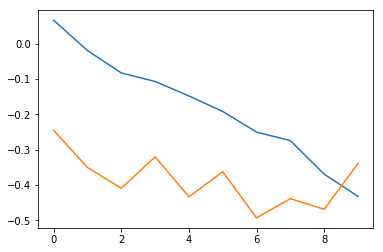

In [0]:
plt.plot(range(epochs),map(np.log10,history.history['loss']))
plt.plot(range(epochs),map(np.log10,history.history['val_loss']))
plt.show()

In [0]:
# get test predictions
y_pred_test = np.zeros(shape=(len(y_test),1))
y_pred_val = np.zeros(shape=(len(y_val),1))
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

In [0]:
def matthews_corrcoef(y_true, y_pred): #balanced metric
    assert y_true.shape == y_pred.shape
    y_pred_pos = 1*(y_pred > 0.5)
    y_pred_neg = 1 - y_pred_pos

    y_pos = 1*(y_true > 0.5)
    y_neg = 1 - y_pos

    tp = np.sum(y_pos * y_pred_pos)
    tn = np.sum(y_neg * y_pred_neg)

    fp = np.sum(y_neg * y_pred_pos)
    fn = np.sum(y_pos * y_pred_neg)
    #print tp , tn , fp ,fn
    numerator = (tp * tn - fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return numerator/denominator

In [47]:
print matthews_corrcoef(y_val,y_pred_val[:,0])
print matthews_corrcoef(y_test,y_pred_test[:,0])
# values are higher because MCC is not supposed to be used in batches but rather the whole dataset

0.2913154597984349
0.3641446014084104


In [48]:
# find the wrong answers
wrong = X_test[(y_test != (y_pred_test[:,0]>0.5)*1)]
wrong_y = y_test[(y_test != (y_pred_test[:,0]>0.5)*1)]
wrong_pred = y_pred_test[(y_test != (y_pred_test[:,0]>0.5)*1)]
wrong.shape

(192, 80)

In [50]:
for i,j,k in zip( wrong,wrong_y,wrong_pred)[0:]:
    id_wrong = np.argmax(np.sum(np.array([data['wordVec2']]) == list(i),(0,2)))
    # print text, label, prediction
    print data.iloc[id_wrong]['data_clean'],j,k,'\n\n\n'

Twilight's Kristen Stewart tells Elle UK she's 'really in love with my girlfriend'American actress Kristen Stewart, who played the girlfriend of Robert Pattinson in the Twilight movie series and subsequently in real life, is for the first time speaking publicly of her current love interest - another woman. 0 [0.8731444] 



USA Gymnastics president resigns in wake of sex abuse scandalThe president of USA Gymnastics resigned in the wake of a scandal in which accusers say he was slow to notify authorities about sexual abuse allegations.Gymnastics chief Steve Penny had faced mounting calls to quit following allegations by hundreds of women who say they have been sexually abused, many of them by former national team doctor Larry Nassar (above) during training camps. 0 [0.52146846] 



Police hunt for gunman after deadly Tel Aviv pub attackIsraeli security forces pressed a manhunt for the gunman who killed two people and wounded seven others at a Tel Aviv pub, with the motive for the attack

# CORECT predictions 

In [51]:
# find the correct answers
wrong = X_test[(y_test == (y_pred_test[:,0]>0.5)*1)]
wrong_y = y_test[(y_test == (y_pred_test[:,0]>0.5)*1)]
wrong_pred = y_pred_test[(y_test == (y_pred_test[:,0]>0.5)*1)]
wrong.shape

(1073, 80)

In [0]:
for i,j,k in zip( wrong,wrong_y,wrong_pred)[0::20]:
    id_wrong = np.argmax(np.sum(np.array([data['wordVec2']]) == list(i),(0,2)))
    # print text, label, prediction
    print data.iloc[id_wrong]['data_clean'],j,k,'\n'

Twilight's Kristen Stewart tells Elle UK she's 'really in love with my girlfriend'American actress Kristen Stewart, who played the girlfriend of Robert Pattinson in the Twilight movie series and subsequently in real life, is for the first time speaking publicly of her current love interest - another woman. 0 [ 0.04554121] 

Unsung heroes of Paris attacks honoured at concertSome 12,000 emergency and health workers, security officials and others honoured at a concert on Monday (Dec 21) in Paris.  0 [ 0.05070087] 

Olympics: IOC under fire for 'confusing mess' after letting Russia escape blanket doping banThe International Olympic Committee on Sunday decided against hitting Russia with a blanket ban from the Rio Games over state-run doping, sparking an immediate backlash from groups that had demanded bold action against cheating. 0 [ 0.00377355] 

Football: Spain's Maria Villar withdraws bid for Uefa top jobAngel Maria Villar, the head of Spain's football association, announces he has wit